Predict `BufferHealth` (seconds ahead in the buffer) only based on network measurements.

**Why?**: The operator may decide to allocate more bandwidth to users whose buffer is suffering.

In [100]:
import pandas as pd # For dataframes (tables)
import matplotlib.pyplot as plt # For plots
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math # for sqrt
import statsmodels.api as sm
import numpy as np # For arange
from sklearn.preprocessing import PolynomialFeatures


# We will use a library that I created for you
import os # To import external python files
import sys# To import external python files
sys.path.insert(0,os.path.abspath('../../course_library') ) # Replace this
                                                            # with the correct
                                                            # path
import feature_engineering                                 
from andrea_models import AndreaLinearRegression

In [84]:
dataset_to_use = 'B1'
mydatasets_folder = "/home/araldo/datasets"
df = pd.read_csv(mydatasets_folder +'/video-qoe-processed/df.'+
                 dataset_to_use+'_2.csv')

# Univariate Polynomial Regression

Let's check what are the most correlated features to `BufferHealth`.

In [85]:
feats = feature_engineering.get_features_correlated_to_target(
        df, target_feature='BufferHealth'
        )
feats

BufferHealth           1.00
BufferProgress_log     0.97
BufferProgress         0.97
BytesReceived0         0.61
PacketsReceived        0.61
BytesReceived          0.61
PacketsReceived0       0.61
KBytesReceived         0.61
PacketsSent0           0.56
PacketsSent            0.53
RelativeTime           0.51
PacketsReceived5       0.50
PacketsReceived_log    0.50
BytesReceived5         0.50
KBytesReceived_log     0.49
BytesReceived_log      0.49
BytesSent0             0.49
PacketsSent_log        0.45
EpochTime             -0.44
StartTime             -0.44
label_num              0.39
BytesSent5             0.37
PacketsSent5           0.37
BytesSent              0.37
BytesSent_log          0.35
BytesSent7            -0.28
PacketsSent7          -0.22
PacketsReceived7      -0.19
BytesReceived7        -0.14
PacketsSent10         -0.12
                       ... 
IPDst21                 NaN
Protocol21              NaN
PacketsSent21           NaN
PacketsReceived21       NaN
BytesSent21         

We can not use `BufferProgress`, as it is not a network-layer measure and the net operator would not have access to the buffer of users.

`BytesReceived` is also highly correlated (to have more seconds-ahead, we need to download more).

[Text(0, 0.5, 'BufferHealth'), Text(0.5, 0, 'BytesReceived')]

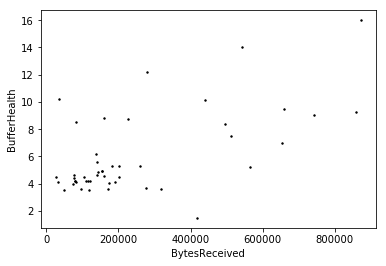

In [86]:
feature = 'BytesReceived'
fig, ax = plt.subplots() # This creates just a canvas
ax.scatter(df[feature],df['BufferHealth'],color='black',
           s=2, label='all samples') # ax is the actual figure
ax.set (xlabel=feature, ylabel='BufferHealth')

Values are squashed on the left, let's use the log-transformed feature to see the dependency better.

[Text(0, 0.5, 'BufferHealth'), Text(0.5, 0, 'BytesReceived_log')]

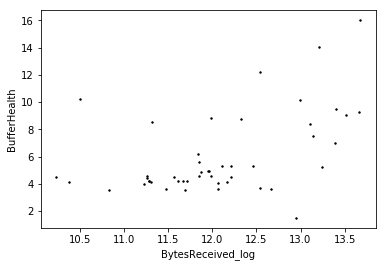

In [87]:
feature = 'BytesReceived_log'
fig, ax = plt.subplots() # This creates just a canvas
ax.scatter(df[feature],df['BufferHealth'],color='black',
           s=2, label='all samples') # ax is the actual figure
ax.set (xlabel=feature, ylabel='BufferHealth')

The dependency is clearer now, although, in terms of Pearson's correlation coefficient 
$$
\rho(\texttt{BytesReceived},\texttt{BufferHealth}) \ge 
\rho(\texttt{BytesReceived_log},\texttt{BufferHealth})
$$ 

Don't be surprised: Pearson's correlation only captures linear dependency and we see that here the dependency is not linear

In [88]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=2)

Let's put in evidence the test samples

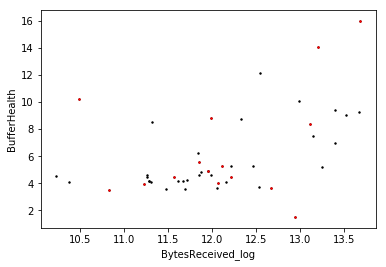

In [89]:
ax.scatter(df_test[feature],df_test['BufferHealth'],color='red',
           s=2, label='test') # ax is the actual figure
fig

OLS linear regression

In [90]:
feature = 'BytesReceived_log'
target = 'BufferHealth'
X_train = df_train[feature]
X_test = df_test[feature]
y_train = df_train[target]
y_test = df_test[target]

X_train_c = sm.add_constant(X_train)
model_lin = sm.OLS(y_train, X_train_c).fit()
model_lin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           BufferHealth   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     17.51
Date:                Fri, 14 Feb 2020   Prob (F-statistic):           0.000229
Time:                        18:00:56   Log-Likelihood:                -64.395
No. Observations:                  32   AIC:                             132.8
Df Residuals:                      30   BIC:                             135.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -13.7603      4.677     -2.942      0.006     -23.312      -4.209
BytesReceived_log     1.6199      0.387      4.185      0.000       0.829       2.410
==============================================================================
Omnibus:                       11.109   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               10.120
Skew:                           1.179   Prob(JB):                      0.00635
Kurtosis:                       4.423   Cond. No.                         172.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The model is significant. Let's test it.

In [92]:
X_test_c = sm.add_constant(X_test)
y_pred = model_lin.predict(X_test_c)
test_RMSE_linear = math.sqrt(mean_squared_error(y_pred, y_test))
print('The test error is of ',test_RMSE_linear,' seconds')

The test error is of  3.722808230494189  seconds


Let's plot the regression line

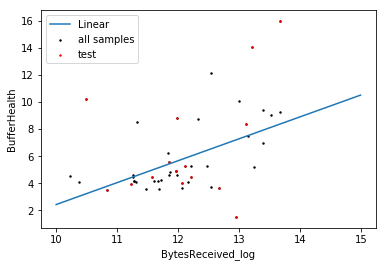

In [93]:
interval = np.arange(10, 15, 0.01)
interval_c = sm.add_constant(interval)
h_values = model_lin.predict(interval_c)
ax.plot(interval,h_values, label="Linear ")
ax.legend()
fig

Not great. We would like to have a curve more flexible than a rigid straight line.

To run a quadratic regression, we first need to add to the column `BytesReceived_log` the column $\texttt{BytesReceived_log}^2$.

In [94]:
# The function fit_transform wants a matrix while X_train is a dataframe
# We need to transform it in array
X_train = X_train.values

# Now X_train is an array. We need to transform it in a matrix
X_train = X_train.reshape(-1,1)


X_train_poly = PolynomialFeatures(degree=2, 
                include_bias=False).fit_transform(X_train)
X_train_poly

array([[ 10.37402229, 107.62033849],
       [ 12.16272141, 147.93179218],
       [ 11.68839023, 136.61846627],
       [ 11.25940002, 126.77408887],
       [ 12.32598674, 151.92994917],
       [ 11.8706069 , 140.91130823],
       [ 12.99278303, 168.81241077],
       [ 13.66424804, 186.71167441],
       [ 11.28062764, 127.25255997],
       [ 11.32280558, 128.2059262 ],
       [ 10.23426503, 104.74018077],
       [ 11.25712958, 126.72296641],
       [ 12.53561377, 157.14161271],
       [ 11.47326946, 131.63591203],
       [ 13.39753148, 179.49384964],
       [ 11.71440402, 137.22726145],
       [ 11.98382245, 143.61200039],
       [ 11.28156071, 127.2736121 ],
       [ 13.24652779, 175.4704984 ],
       [ 13.14613264, 172.82080331],
       [ 11.31062567, 127.93025294],
       [ 12.54261274, 157.31713427],
       [ 13.39098953, 179.31860069],
       [ 13.51802997, 182.73713426],
       [ 12.21554762, 149.21960356],
       [ 12.466088  , 155.40335001],
       [ 11.61205561, 134.83983554],
 

In [95]:
X_train_poly_c = sm.add_constant(X_train_poly)
model_quadr = sm.OLS(y_train, X_train_poly_c).fit()
model_quadr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           BufferHealth   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     10.23
Date:                Fri, 14 Feb 2020   Prob (F-statistic):           0.000435
Time:                        18:00:56   Log-Likelihood:                -63.209
No. Observations:                  32   AIC:                             132.4
Df Residuals:                      29   BIC:                             136.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         64.2576     52.452      1.225      0.230     -43.018     171.533
x1           -11.3349      8.684     -1.305      0.202     -29.097       6.427
x2             0.5351      0.358      1.493      0.146      -0.198       1.268
==============================================================================
Omnibus:                       18.793   Durbin-Watson:                   2.102
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.331
Skew:                           1.572   Prob(JB):                     5.21e-06
Kurtosis:                       5.893   Cond. No.                     2.43e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.43e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Let's plot the line

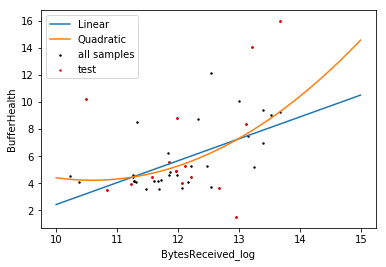

In [96]:
interval = interval.reshape(-1,1)
interval_poly = PolynomialFeatures(degree=2, 
                include_bias=False).fit_transform(interval)
interval_poly_c = sm.add_constant(interval_poly)
h_values = model_quadr.predict(interval_poly_c)

ax.plot(interval,h_values, label="Quadratic")
ax.legend()
fig

In [97]:
X_test = X_test.values.reshape(-1,1)
X_test_poly = PolynomialFeatures(degree=2, 
                include_bias=False).fit_transform(X_test)
X_test_poly_c = sm.add_constant(X_test_poly)

y_pred = model_quadr.predict(X_test_poly_c)
test_RMSE_quadr = math.sqrt(mean_squared_error(y_pred, y_test))
print('The test error is ',test_RMSE_quadr,
          ' seconds; with linear regression it was', test_RMSE_linear)

The test error is  3.4349359394194794  seconds; with linear regression it was 3.722808230494189


Let's try with cubic regression

RMSE:  0.17070005522339976  seconds; With quadratic regression it was  3.4349359394194794


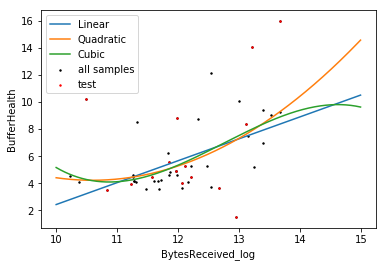

In [98]:
mydegree = 3
X_train_poly = PolynomialFeatures(degree=mydegree, 
                include_bias=False).fit_transform(X_train)
X_train_poly_c = sm.add_constant(X_train_poly)
model_cub = sm.OLS(y_train, X_train_poly_c).fit()

X_test_poly = PolynomialFeatures(degree=mydegree, 
                include_bias=False).fit_transform(
                        X_test)
X_test_poly_c = sm.add_constant(X_test_poly)
y_test = model_cub.predict(X_test_poly_c)
test_RMSE_cub = math.sqrt(mean_squared_error(y_pred, y_test))
print("RMSE: ", test_RMSE_cub, " seconds; With quadratic regression it was ",
             test_RMSE_quadr)

### plot
interval_poly = PolynomialFeatures(degree=mydegree, 
                include_bias=False).fit_transform(interval)
interval_poly_c = sm.add_constant(interval_poly)
h_values = model_cub.predict(interval_poly_c)

ax.plot(interval,h_values, label="Cubic")
ax.legend()
fig

On average, we make an error of 0.2 seconds!

Let's increase a lot the degree of the polynomial

RMSE:  0.7000977366627632


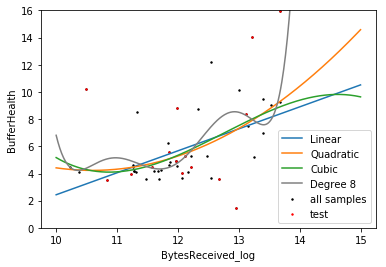

In [99]:
mydegree = 8
X_train_poly = PolynomialFeatures(degree=mydegree, 
                include_bias=False).fit_transform(X_train)
X_train_poly_c = sm.add_constant(X_train_poly)
model_high = sm.OLS(y_train, X_train_poly_c).fit()

X_test_poly = PolynomialFeatures(degree=mydegree, 
                include_bias=False).fit_transform(
                        X_test)
X_test_poly_c = sm.add_constant(X_test_poly)
y_test = model_high.predict(X_test_poly_c)
RMSE_now = math.sqrt(mean_squared_error(y_pred, y_test))
print("RMSE: ", RMSE_now)

### plot
interval_poly = PolynomialFeatures(degree=mydegree, 
                include_bias=False).fit_transform(interval)
interval_poly_c = sm.add_constant(interval_poly)
h_values = model_high.predict(interval_poly_c)


ax.plot(interval,h_values, label="Degree "+str(mydegree), color="gray" )
ax.legend()
ax.set_ylim([0, 16] )
fig

This is a typical example of overfit.

The model is so flexible that it can adapt **too** well to training data. 



**Generalization** means instead to "step back" from the observed data and not adapting too much